# Özel (Custom) Transformer

In [1]:
import pandas as pd
import seaborn as sns

👉 Bu veri setini kullanacağız:

In [2]:
data = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/custom_transformer_data.csv")
data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


- Veri setindeki her bir gözlem, bir ürünün bir `seller_state`’ten bir `customer_state`’e teslim edilmesini temsil eder.  
- Diğer sütunlar, her bir ürünün paketleme özelliklerini açıklar.

🎯 Hedef, sipariş ile teslimat arasındaki gün sayısıdır.

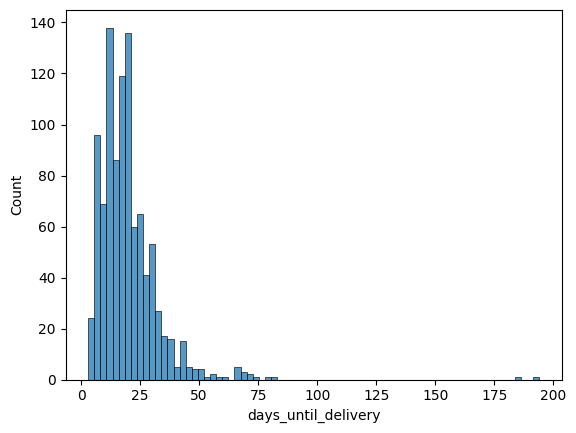

In [3]:
#  Hedefi kontrol et
sns.histplot(data.days_until_delivery);

## 1. Pipeline

👉 `pipe` adlı bir scikit-learn pipeline oluşturun:

- Boyut feature’larından (`dimensions`) bir `volume` feature’ı türetin
- Eğitim için orijinal ürün boyut feature’larını koruyun
- Tüm sayısal feature’ları ölçekleyin
- Kategorik feature’ları encode edin
- Varsayılan ayarlarla bir `Ridge` regresyon estimator’ı ekleyin

**Not:** Bu challenge için holdout yöntemi yok sayılacaktır; yani `train_test_split` kullanmanıza gerek yoktur!

<details><summary><strong>İpuçları</strong></summary>

- Ön işlenmiş feature matrisinizi oluşturmanın birçok yolu vardır (`ColumnTransformer` ve/veya `FeatureUnion` kullanarak). 
    
- Dönüştürülmüş feature matrisiniz garip görünüyorsa, bunun nedeni `OneHotEncoder(sparse_output=True)` varsayılan davranışıyla matrisin "sparse" olarak saklanması olabilir. Bunu tekrar dense bir matrise çevirmek için `.todense()` kullanın.

- Varsayılan NumPy array çıktısı yerine sütun adlarıyla birlikte bir Pandas DataFrame çıktısı almak için, final pipeline’ınızda `.set_output(transform='pandas')` kullanın. (Bunu her bir transformer üzerinde tek tek ayarlamanıza gerek yoktur. Pipeline üzerinde ayarlarsanız, bunu alt aşamalara da aktarır.)

</details>

<br>

<details><summary><strong>Daha fazla ipucu: adım adım yönlendirme</strong> (yalnızca takılırsanız açın)</summary>

Pipeline’ı oluşturmanın en kolay yolu budur.

1. Uzunluk, genişlik ve yükseklik verildiğinde hacmi hesaplayan bir python `function` oluşturun.
2. Aşağıdakilerden oluşan bir hacim hesaplayıcı pipeline oluşturun:
   1. Python `function`’ınızı kullanan bir `FunctionTransformer`.
   1. Ardından bir scaler
3. `ColumnTransformer` kullanarak tam bir preprocessor oluşturun:
   - Orijinal sayısal feature’lar için bir scaler.
   - Kategorik feature’lar için bir encoder.
   - Uzunluk, genişlik ve yükseklik feature’ları için hacim hesaplayıcı pipeline’ınız.
4. Son olarak, tam preprocessor’ınızı ve ardından `Ridge` modelini içeren bir pipeline oluşturun.

</details>

In [11]:
# ======================================================
# IMPORTLAR
# ======================================================

import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge


# ======================================================
# CUSTOM TRANSFORMER
# ======================================================

class VolumeAdder(BaseEstimator, TransformerMixin):
    """
    Ürün boyutlarından hacim (volume) feature'ı üretir.
    Orijinal boyut feature'larını KORUR.
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["product_volume_cm3"] = (
            X["product_length_cm"]
            * X["product_height_cm"]
            * X["product_width_cm"]
        )
        return X

    def set_output(self, transform=None):
        # Pipeline.set_output uyumu için
        return self


# ======================================================
# FEATURE GRUPLARI
# ======================================================

numeric_features = [
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
    "product_volume_cm3"
]

categorical_features = [
    "customer_state",
    "seller_state"
]


# ======================================================
# PREPROCESSOR
# ======================================================

preprocessor = ColumnTransformer(
    transformers=[
        # Sayısal feature'lar
        ("num", StandardScaler(), numeric_features),

        # Kategorik feature'lar
        # KRİTİK DÜZELTME: sparse_output=False
        ("cat", OneHotEncoder(handle_unknown="ignore",sparse_output=False,drop="if_binary"), categorical_features)

    ]
)


# ======================================================
# PIPELINE
# ======================================================

pipe = Pipeline(steps=[
    ("volume_adder", VolumeAdder()),
    ("preprocessor", preprocessor),
    ("model", Ridge())
])

# 🔥 Pandas output artık SORUNSUZ
pipe.set_output(transform="pandas")


# ======================================================
# KULLANIM
# ======================================================

X = data.drop("days_until_delivery", axis=1)
y = data["days_until_delivery"]

pipe.fit(X, y)

X_transformed = pipe[:-1].transform(X)
X_transformed.head()


,num__product_weight_g,num__product_length_cm,num__product_height_cm,num__product_width_cm,num__product_volume_cm3,cat__customer_state_AL,cat__customer_state_AM,cat__customer_state_AP,cat__customer_state_BA,cat__customer_state_CE,...,cat__customer_state_PR,cat__customer_state_RJ,cat__customer_state_RN,cat__customer_state_RO,cat__customer_state_RS,cat__customer_state_SC,cat__customer_state_SE,cat__customer_state_SP,cat__customer_state_TO,cat__seller_state_SP
0,-1.132807,0.034942,-1.355364,0.742229,-1.087075,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.328769,1.033274,-0.986783,-0.233960,-0.729725,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.132807,0.034942,-1.355364,0.742229,-1.087075,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.132807,0.034942,-1.355364,0.742229,-1.087075,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.132807,0.034942,-1.355364,0.742229,-1.087075,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### 🧪  pipe'ını test et

In [12]:
from nbresult import ChallengeResult

pipe_test = pipe

# Çökmediğini kontrol edin
assert pipe_test.fit(X, y)

result = ChallengeResult(
    'pipe',
    shape = pipe_test[:-1].fit_transform(X).shape
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/wit/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/wit/code/S17D1-S-Data-Custom-Transformer/tests
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 1 item

test_pipe.py::TestPipe::test_pipe_not_crashing PASSED                    [100%]

============================== 1 passed in 1.54s ===============================


💯 You can commit your code:

git add tests/pipe.pickle

git commit -m 'Completed pipe step'

git push origin master



## 2. Train ve Predict

👇 `data`’nın tüm eğitim veri setiniz olduğunu varsayalım.

- Bu veri seti üzerinde pipeline’ınızı `cross_validate` edin (❗️düşük $R^2$ skorları beklenmektedir)
- Şimdi de yeni bir sipariş aldığınızı varsayın: `new_data`  
  Teslimat süresini tahmin edin ve sonucu `prediction` adlı değişkende saklayın

In [ ]:
new_data = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/custom_transformer_new_order.csv")
new_data

In [ ]:
# SENİN KODUN BURAYA

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'prediction',
    prediction = prediction
)

result.write()
print(result.check())


🏁 Tebrikler. Not defterinizi eklemeyi, kaydetmeyi ve göndermeyi unutmayın.